In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from functools import cmp_to_key
import pickle
import datetime
from scipy import ndimage
import math
import imageio

from pysift import generateBaseImage, computeNumberOfOctaves, generateGaussianKernels, generateGaussianImages, \
    generateDoGImages, findScaleSpaceExtrema, removeDuplicateKeypoints, convertKeypointsToInputImageSize, generateDescriptors, \
    computeKeypointsWithOrientations, isPixelAnExtremum, localizeExtremumViaQuadraticFit, compareKeypoints, unpackOctave

from testing_pysift_utils import rotate_image_without_resize, pickle_keypoint_with_descriptor, unpickle_keypoint_with_descriptor, \
    get_gaussian_images_from_image

In [2]:
# default params
sigma = 1.6
num_intervals = 3
assumed_blur = 0.5
image_border_width = 5
contrast_threshold = 0.04

In [3]:
image = cv2.imread('box.png', 0)
keypoint_index = 587  # 587 here is 459 for sift
use_pickled = True

In [4]:
image = image.astype('float32')
base_image = generateBaseImage(image, sigma, assumed_blur)
num_octaves = computeNumberOfOctaves(base_image.shape)
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
dog_images = generateDoGImages(gaussian_images)

In [5]:
keypoint, descriptor = unpickle_keypoint_with_descriptor('zimnica/pickled_keypoint' + str(keypoint_index) + '_with_descriptor20200327_121004.pickle')
print(keypoint.angle, keypoint.size)
print()

308.7840270996094 192.53421020507812 4.498647689819336 3.3157284259796143 0.017142852768301964 16253184 -1
[  3.   5.  10.  32.  64.  18.  11.   3.  64.  48.  17.  14.  28.   2.
   4.   6.  12.   5.   0.   3.  98.   6.   0.   0.   2.   1.   0.   0.
 150.  23.   0.   0.  10.   3.   1.  14. 150.  10.   0.   1. 150.  20.
   1.   7.  57.   5.   0.   5.  32.   2.   0.   0. 115.  10.   1.   1.
   4.   0.   0.   0. 150.  28.   1.   0.  16.   1.   1.  66. 134.   7.
   1.   5. 150.   9.   1.  13.  39.   3.   1.  34.  31.   1.   0.   1.
 109.   8.   1.   5.   6.   0.   0.   0. 150.  36.   1.   1.   8.   0.
   4.  15.  57.  46.  34.   8.  74.   9.   5.   5.  12.   7.  34.  42.
  18.   2.   2.   8.  69.   4.   1.   4.   7.   0.   0.   0. 150.  27.
   1.   2.]
3.3157284259796143 4.498647689819336



In [6]:
# TODO keep in mind that in opencv the order is reversed!!
patch_centre_x = int(keypoint.pt[1])
patch_centre_y = int(keypoint.pt[0])
patch_diameter = int(2 * math.floor(keypoint.size / 2) + 1)  # rounding it to the nearest odd number
patch_radius = (patch_diameter - 1) // 2

# TODO check the +1 part
patch = image[patch_centre_x - patch_diameter: patch_centre_x + patch_diameter + 1, patch_centre_y - patch_diameter: patch_centre_y + patch_diameter + 1]  # using the diameter and not the radius to get a larger patch

image shape (223, 324)
patch shape (11, 11)
patch diameter 5
patch radius 2
187 197
303 313


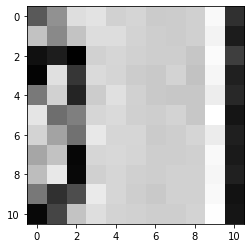

In [7]:
# just printing
print("image shape", image.shape)
print("patch shape", patch.shape)
print("patch diameter", patch_diameter)
print("patch radius", patch_radius)
# TODO this could go out of the border and create an error!
print(patch_centre_x - patch_diameter, patch_centre_x + patch_diameter)
print(patch_centre_y - patch_diameter, patch_centre_y + patch_diameter)
plt.imshow(patch, cmap="gray")
plt.show()

In [8]:
keypoint = cv2.KeyPoint(patch.shape[1] // 2, patch.shape[0] // 2, _size=4.49870252609, _angle=3.31573486328, _octave=256)
keypoints = [keypoint]

patch_gaussian_images = get_gaussian_images_from_image(patch)

In [10]:
# gaussian_images_cropped = []

# for octave_index in range(num_octaves):
#     gaussian_images_in_octave = []
#     gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
#     for gaussian_kernel in gaussian_kernels[1:]:
#         image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
#         gaussian_images_in_octave.append(image)
#     gaussian_images.append(gaussian_images_in_octave)
#     octave_base = gaussian_images_in_octave[-3]
#     image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
# gaussian_images_cropped = np.array(gaussian_images_cropped)

In [19]:
# gaussian_images_cropped = []

# for octave in range(gaussian_images.shape[0]):
#     gaussian_images_in_octave = []
#     for layer in range(gaussian_images.shape[1]):
#         #todo check
#         if octave == 1 and layer == 1:
#             print(gaussian_images[octave, layer].shape)
#             gaussian_image_cropped = gaussian_images[octave, layer][patch_centre_x - patch_diameter: patch_centre_x + patch_diameter + 1, patch_centre_y - patch_diameter: patch_centre_y + patch_diameter + 1]
#         else:
#             gaussian_images_in_octave.append(gaussian_images[octave, layer])
#     gaussian_images_in_octave = np.array(gaussian_images_in_octave)
#     gaussian_images_cropped.append(gaussian_images_in_octave)
# gaussian_images_cropped = np.array(gaussian_images_cropped)

(223, 324)


In [54]:
gaussian_image_cropped = gaussian_images.copy()

In [68]:
for i in range(gaussian_images_cropped[1].shape[0]):
    print(gaussian_images[1, i].shape)
    gaussian_image_cropped = gaussian_images[1, i][patch_centre_x - patch_diameter: patch_centre_x + patch_diameter + 1, patch_centre_y - patch_diameter: patch_centre_y + patch_diameter + 1]

(223, 324)
(223, 324)
(223, 324)
(223, 324)
(223, 324)
(223, 324)


In [55]:
gaussian_images_cropped[1, 1].shape

(223, 324)

In [58]:
gaussian_image_cropped = gaussian_images[1, 1][patch_centre_x - patch_diameter: patch_centre_x + patch_diameter + 1, patch_centre_y - patch_diameter: patch_centre_y + patch_diameter + 1]

In [60]:
gaussian_image_cropped.shape

(11, 11)

In [61]:
gaussian_images_cropped[1, 1] = gaussian_image_cropped

In [62]:
gaussian_images_cropped[1, 1].shape

(11, 11)

In [67]:
descriptors = generateDescriptors(keypoints, gaussian_image_cropped)

ValueError: not enough values to unpack (expected 2, got 0)

In [64]:
descriptors

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,   2.,   0.,
          0.,   1.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   8.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,
          3.,   0.,   0.,   0.,   0.,   0.,   1., 206.,  70.,   0.,   0.,
         23.,   2.,   0.,  21., 194.,  15.,   0.,   0., 206.,  20.,   0.,
          2.,   0.,   0.,   0.,   0.,  11.,   1.,   0.,   0.,   8.,   1.,
          0.,   0.,   0.,   0.,   0.,   1., 206.,  27.,   0.,   0.,  16.,
          2.,   0.,  53., 206.,   4.,   0.,   0., 206.,  29.,   0.,  15.,
          0.,   0.,   0.,   0.,  13.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,   0.,   0.,   0.,
          0.,   4.,   4.,   0.,   0.,   0.,   4.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)